# Ablation: Semi-Supervised Architope - for Reviews
---
- This code Implements Algorithm 3.2 of the "PC-NNs" paper.

#### Mode: Code-Testin Parameter(s)

In [1]:
trial_run = True

### Meta-parameters

In [2]:
# Test-size Ratio
test_size_ratio = 1-(1/24)
min_width = 100
# Ablation Finess
N_plot_finess = 10
# min_parts_threshold = .001; max_parts_threshold = 0.9
N_min_parts = 1; N_max_plots = 20
Tied_Neurons_Q = True
# Partition with Inputs (determine parts with domain) or outputs (determine parts with image)
Partition_using_Inputs = True
# Cuttoff Level
gamma = .5

In [3]:
#------------------------------------#
# Only For Motivational Example Only #
#------------------------------------#
## Hyperparameters
percentage_in_row = .25
N = 10**4

def f_1(x):
    return x
def f_2(x):
    return np.exp(-x)
x_0 = 0
x_end = 1
import seaborn as sns

### Hyperparameters

Only turn of if running code directly here, typically this script should be run be called by other notebooks.  

In [4]:
# load dataset
results_path = "./outputs/models/"
results_tables_path = "./outputs/results/"
raw_data_path_folder = "./inputs/raw/"
data_path_folder = "./inputs/data/"

### Import

Using TensorFlow backend.


Deep Feature Builder - Ready
Deep Classifier - Ready
Get S&P Data
#================================================#
 Training Datasize: 574 and test datasize: 25.  
#================================================#
Get Crypto Data
#================================================#
 Training Datasize: 203 and test datasize: 9.  
#================================================#


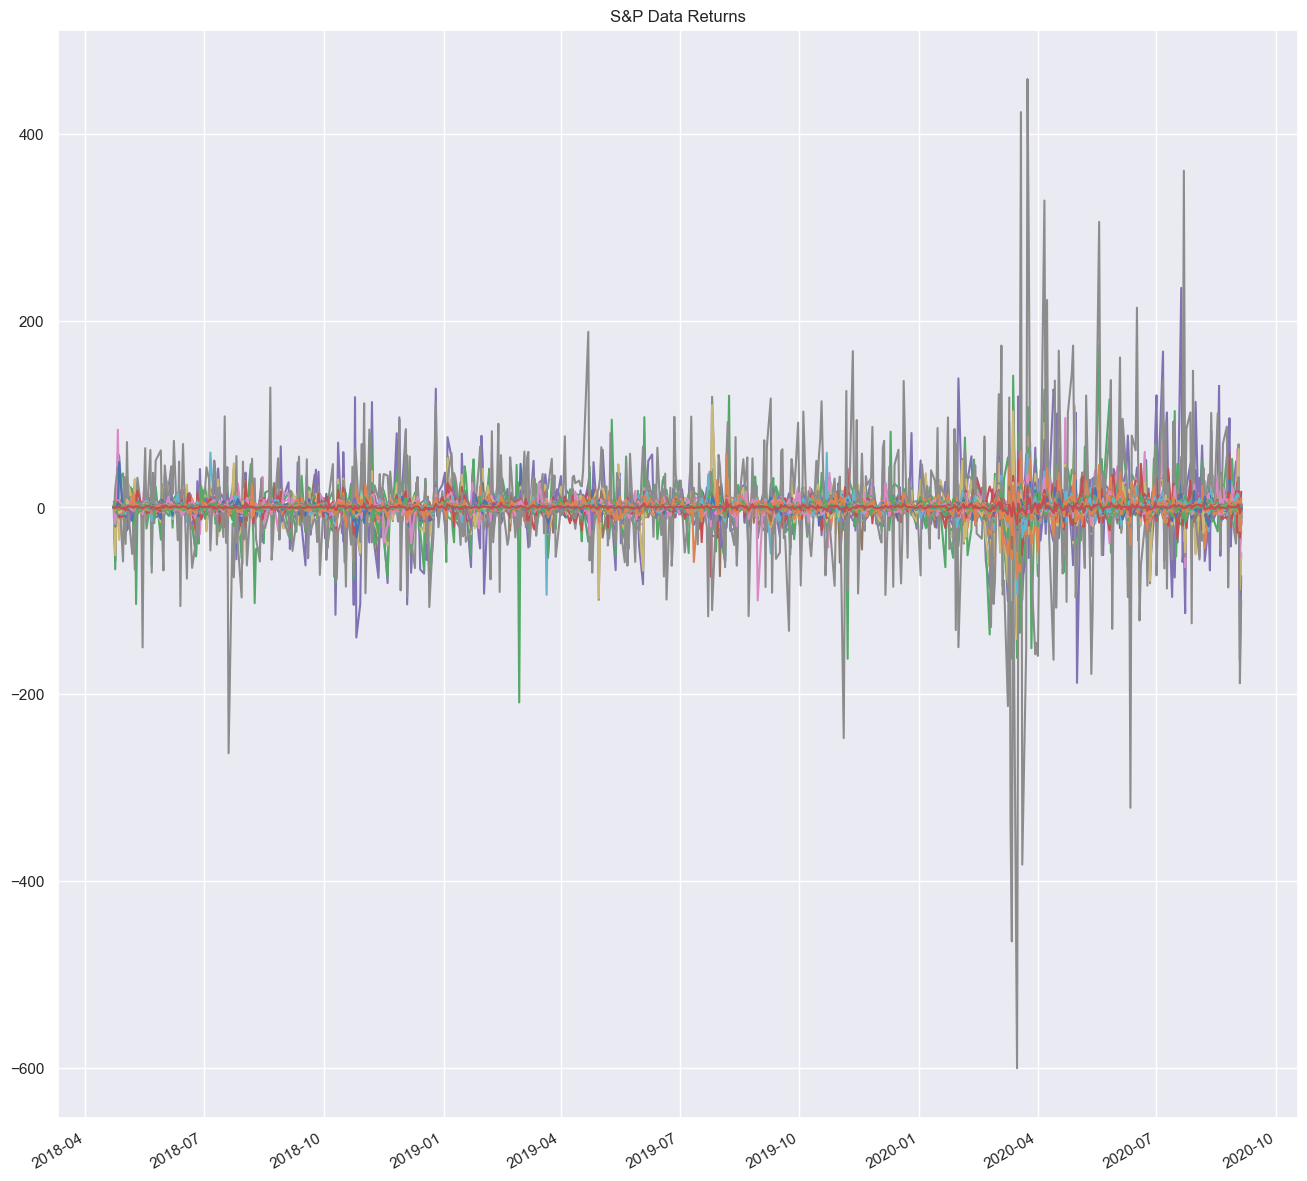

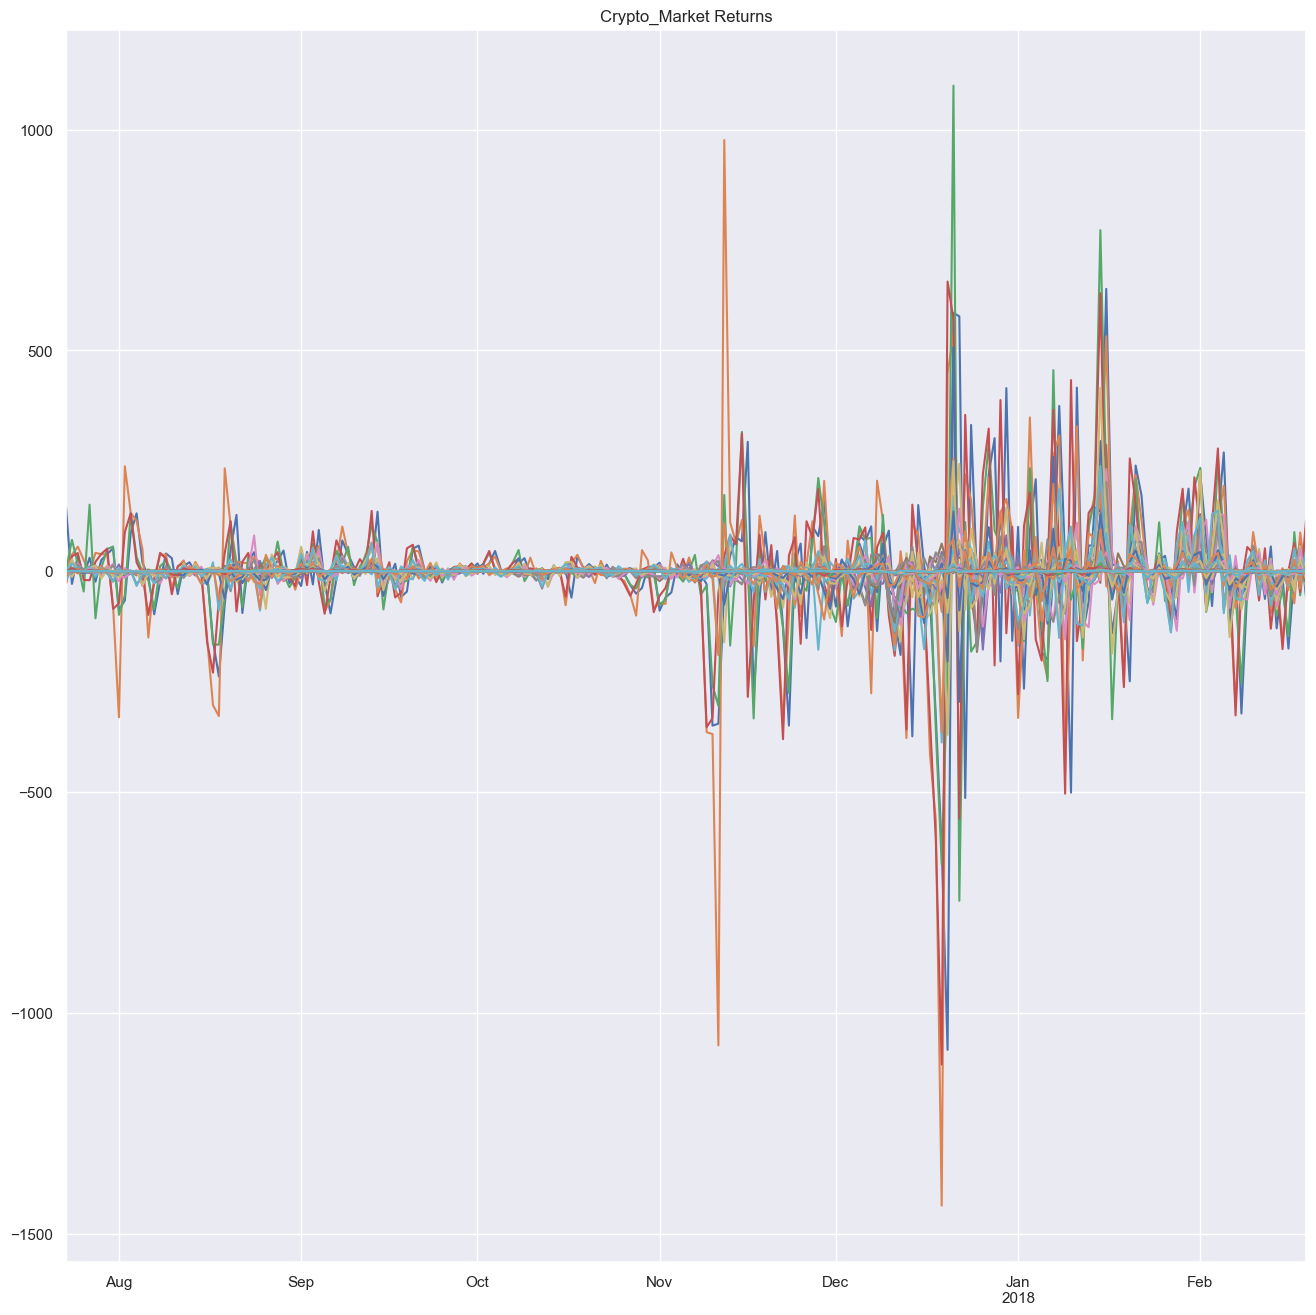

In [5]:
# Load Packages/Modules
exec(open('Init_Dump.py').read())
# Load Hyper-parameter Grid
exec(open('Grid_Enhanced_Network.py').read())
# Load Helper Function(s)
exec(open('Helper_Functions.py').read())
# Pre-process Data
if Option_Function != "Motivational_Example": 
    exec(open('Financial_Data_Preprocessor.py').read())
else:
    print(1)
    exec(open('Motivational_Example.py').read())
    print("Training Data size: ",X_train.shape[0])
# exec(open('Prepare_Data_California_Housing.py').read())
# Import time separately
import time

# TEMP
# import pickle_compat
# pickle_compat.patch()
# param_grid_Vanilla_Nets['input_dim']=X_train.shape[1]
sns.set()
plt.show()

### Set Seed

In [6]:
random.seed(2021)
tf.random.set_seed(2021)

#### Pre-Process:
- Convert Categorical Variables to Dummies
- Remove Bad Column
- Perform Training/Test Split

# Random Lipschitz Partition Builder

We implement the random paritioning method of [Yair Bartal](https://scholar.google.com/citations?user=eCXP24kAAAAJ&hl=en):
- [On approximating arbitrary metrices by tree metrics](https://dl.acm.org/doi/10.1145/276698.276725)

The algorithm is summarized as follow:

---

## Algorithm:
 1. Sample $\alpha \in [4^{-1},2^{-1}]$ randomly and uniformly,
 2. Apply a random suffle of the data, (a random bijection $\pi:\{i\}_{i=1}^X \rightarrow \mathbb{X}$),
 3. For $i = 1,\dots,I$:
   - Set $K_i\triangleq B\left(\pi(i),\alpha \Delta \right) - \bigcup_{j=1}^{i-1} P_j$
 
 4. Remove empty members of $\left\{K_i\right\}_{i=1}^X$.  
 
 **Return**: $\left\{K_i\right\}_{i=1}^{\tilde{X}}$.  
 
 For more details on the random-Lipschitz partition of Yair Bartal, see this [well-written blog post](https://nickhar.wordpress.com/2012/03/26/lecture-22-random-partitions-of-metric-spaces/).

## Define Random Partition Builder

#### Explicit Partion Builder:
Implements exactly Algorithm 2:

In [7]:
def Random_Lipschitz_Partioner(X_in,
                               y_in,
                               N_parts_to_get=4):

    # Compute Size of each part
    size_part_reference = int(round(X_in.shape[0]/N_parts_to_get))

    # Apply random bijection #
    #------------------------#
    ## Get random bijection indices
    random_bijection_indices = np.random.choice(range(X_in.shape[0]),size=X_in.shape[0], replace=False)
    ## Apply random bijections
    X_in_shuffled = X_in[random_bijection_indices,:]
    y_in_shuffled = y_in[random_bijection_indices,:]

    # Initialize Lists #
    #------------------#
    X_parts = []
    y_parts = []

    for i_th_part_to_get in range(N_parts_to_get):
        # Build random balls #
        #--------------------#
        ## Sample random radius
        size_part = int(np.maximum(1,np.round(size_part_reference*np.random.uniform(low=.5,high=1.5,size=1)[0])))
        ## Sample random point
        X_center_loop_index = np.random.choice(range(X_in_shuffled.shape[0]),size=1, replace=False)
        X_center_loop = X_in_shuffled[X_center_loop_index,:]
        ## Compute Typical Distances from Center
        distances_loop = X_center_loop-X_in_shuffled
        distances_loop = np.linalg.norm(distances_loop, axis=1)

        # Remove Random Ball from Dataset
        if size_part <= len(distances_loop):
            ## Identify indices
            indices_smallest_to_random_ball = np.argsort(distances_loop)[:size_part]
        else:
            print('Final Loop')
            indices_smallest_to_random_ball = np.array(range(X_in_shuffled.shape[0]))
        ## Extract Parts
        X_current_part_loop = X_in_shuffled[indices_smallest_to_random_ball,:]
        y_current_part_loop = y_in_shuffled[indices_smallest_to_random_ball,:]
        ## Append to List of Parts
        X_parts.append(X_current_part_loop)
        y_parts.append(y_current_part_loop)

        # Remove Selected Entries From Array #
        #------------------------------------#
        X_in_shuffled = np.delete(X_in_shuffled,indices_smallest_to_random_ball,axis=0)
        y_in_shuffled = np.delete(y_in_shuffled,indices_smallest_to_random_ball,axis=0)

        # Failsafe if procedure has terminated
        if X_in_shuffled.shape[0] == 0:
            print('breaking early')
            break
    # Count Number of Parts Generated        
    N_parts_generated = len(X_parts)
    # Output Parts
    return X_parts, y_parts, N_parts_generated

# Ablation Function

In [8]:
def get_PCNNs(N_parts,X_train,y_train,X_test,y_test):

    # Initialization(s) #
    #-------------------#
    N_neurons = 0
    L_timer = 0
    P_timer = 0
    Mean_Width_Subnetworks = 0

    # Partitioner Begin #
    #-------------------#
    import time
    partitioning_time_begin = time.time()
    print('-------------------------------------------------------')
    print('Randomly Initialized Parts - Via Randomized Algorithm 2')
    print('-------------------------------------------------------')
    if Partition_using_Inputs == True:
        X_parts_list, y_parts_list, N_parts_Generated_by_Algo_2 = Random_Lipschitz_Partioner(X_train.to_numpy(),
                                                                                             y_train.reshape(-1,1),
                                                                                             N_parts)
    else:
        X_parts_list, y_parts_list, N_parts_Generated_by_Algo_2 = Random_Lipschitz_Partioner(y_train.reshape(-1,1),
                                                                                             X_train.to_numpy(),
                                                                                             N_parts)
    partitioning_time = time.time() - partitioning_time_begin
    print('The_parts_listhe number of parts are: ' + str(N_parts_Generated_by_Algo_2)+'.')
    ############# Partitioner End ########

    print('-----------------------------------------------------')
    print('Training Sub-Networks on Each Randomly Generated Part')
    print('-----------------------------------------------------')
    # Time-Elapse (Start) for Training on Each Part #
    PCNN_timer = time.time(); PCNN_timer = -math.inf; N_params_Architope = 0; N_params_tally = 0
    # Remove Eager Execution Error(s)
    tf.compat.v1.disable_eager_execution()
    # Automatically Initialize Correct Input/Output Dimension(s)
    param_grid_Vanilla_Nets['input_dim'] = [X_train.shape[1]]; param_grid_Vanilla_Nets['output_dim'] = [1]
    param_grid_Deep_Classifier['input_dim'] = [X_train.shape[1]]
    # Decide if/or not to tie neuron numbers of sub-patterns together
    if Tied_Neurons_Q == True:
        param_grid_Vanilla_Nets['height'] = [int(np.maximum(round(param_grid_Vanilla_Nets['height'][0]/N_parts),min_width))]
        param_grid_Vanilla_Nets['epochs'] = [int(np.maximum(round(param_grid_Vanilla_Nets['epochs'][0]/int(round(np.sqrt(N_parts)))),min_width))]
#         param_grid_Deep_Classifier['height'] = [int(np.maximum(round(param_grid_Deep_Classifier['height'][0]/N_parts),min_width))]

    for current_part in range(N_parts_Generated_by_Algo_2):
        # Update User #
        #-------------#
        print('-----------------------------------------------------------')
        print('Currently Training Part: '+str(current_part)+'/'+str(N_parts_Generated_by_Algo_2 )+'Total Parts.')
        print('-----------------------------------------------------------')

        # Timer for Part
        part_training_timer = time.time()
        # Get Data for Sub-Pattern
        X_loop = pd.DataFrame(X_parts_list[current_part])
        y_loop = (y_parts_list[current_part]).reshape(-1,)
        # Train ffNN
        y_hat_part_loop, y_hat_part_loop_test, N_neurons_PCNN_loop = build_ffNN(n_folds = 4, 
                                                                              n_jobs = n_jobs,
                                                                              n_iter = n_iter, 
                                                                              param_grid_in = param_grid_Vanilla_Nets, 
                                                                              X_train= X_loop, 
                                                                              y_train=y_loop,
                                                                              X_test_partial=X_train,
                                                                              X_test=X_test,
                                                                              NOCV=True)
        # Reshape y
        ## Training
        y_train.shape = (y_train.shape[0], param_grid_Vanilla_Nets['output_dim'][0])
        y_hat_part_loop.shape = (y_hat_part_loop.shape[0], param_grid_Vanilla_Nets['output_dim'][0])
        ## Testing
        y_test.shape = (y_test.shape[0], param_grid_Vanilla_Nets['output_dim'][0])
        y_hat_part_loop_test.shape = (y_hat_part_loop_test.shape[0], param_grid_Vanilla_Nets['output_dim'][0])

        # Append predictions to data-frames
        ## If first prediction we initialize data-frames
        if current_part==0:
            # Register quality
            training_quality = np.array(np.abs(y_hat_part_loop-y_train)).reshape(y_hat_part_loop.shape[0],1)

            # Save Predictions
            predictions_train = y_hat_part_loop.reshape(y_hat_part_loop.shape[0],1)
            predictions_test = y_hat_part_loop_test.reshape(y_hat_part_loop_test.shape[0],1)


        ## If not first prediction we append to already initialized dataframes
        else:
        # Register Best Scores
            #----------------------#
            # Write Predictions 
            # Save Predictions
            y_hat_train_loop = y_hat_part_loop.reshape(predictions_train.shape[0],1)
            predictions_train = np.append(predictions_train,y_hat_train_loop,axis=1)
            y_hat_test_loop = y_hat_part_loop_test.reshape(predictions_test.shape[0],1)
            predictions_test = np.append(predictions_test,y_hat_test_loop,axis=1)

            # Evaluate Errors #
            #-----------------#
            # Training
            prediction_errors = np.abs(y_hat_train_loop-y_train)
            training_quality = np.append(training_quality,prediction_errors.reshape(training_quality.shape[0],1),axis=1)

        #==============================#
        # Update Performance Metric(s) #
        #==============================#
        part_training_timer = time.time() - part_training_timer
        # L-Time
        L_timer += partitioning_time
        # P-Time
        P_timer = max(P_timer,part_training_timer)
        # N. Params
        N_neurons += N_neurons_PCNN_loop
        # Mean Width for Sub-Network(s)
        Mean_Width_Subnetworks += param_grid_Vanilla_Nets['height'][0]

    # Take Mean of Width(s)
    Mean_Width_Subnetworks = Mean_Width_Subnetworks/N_parts_Generated_by_Algo_2
    print('-----------------------')
    print('Training Deep Zero-Sets')
    print('-----------------------')


    # Time Elapsed for Training Deep Zero-Sets
    Deep_Zero_Sets_timer = time.time()

    ## Initialize Classes Labels
    # No pooling (classical)
    partition_labels_training_integers = np.argmin(training_quality,axis=-1)
    # Max Pooling
#     partition_labels_training_integers = (training_quality == training_quality.min(axis=1)[:,None]).astype(int)
    partition_labels_training = pd.DataFrame(pd.DataFrame(partition_labels_training_integers) == 0)
    ## Build Classes
    for part_column_i in range(1,(training_quality.shape[1])):
        partition_labels_training = pd.concat([partition_labels_training,
                                               (pd.DataFrame(partition_labels_training_integers) == part_column_i)
                                              ],axis=1)
    ## Convert to integers
    partition_labels_training = partition_labels_training+0
    ## Train simple deep classifier
    tf.compat.v1.disable_eager_execution()
    predicted_classes_train, predicted_classes_test, N_params_deep_classifier = build_simple_deep_classifier(n_folds = CV_folds, 
                                                                                                        n_jobs = n_jobs, 
                                                                                                        n_iter =n_iter, 
                                                                                                        param_grid_in=param_grid_Deep_Classifier, 
                                                                                                        X_train = X_train.values, 
                                                                                                        y_train = partition_labels_training.values,
                                                                                                        X_test = X_test.values)
    # Get Binary Classes (Discontinuous Unit)
    ## Training Set
    predicted_classes_train = ((predicted_classes_train>gamma)*1).astype(int)
    ## Testing Set
    predicted_classes_test = ((predicted_classes_test > gamma)*1).astype(int)
    # Get PC-NN Prediction(s)
    ## Train
    PCNN_prediction_y_train = (predictions_train*predicted_classes_train).sum(axis=1)
    ## Test
    PCNN_prediction_y_test = (predictions_test*predicted_classes_test).sum(axis=1)

    # End Timer
    Deep_Zero_Sets_timer = time.time() - Deep_Zero_Sets_timer

    print('-----------------------------------')
    print('Computing Final Performance Metrics')
    print('-----------------------------------')
    # Time-Elapsed Training Deep Classifier

    # Update Times
    L_timer +=Deep_Zero_Sets_timer
    P_timer +=Deep_Zero_Sets_timer
    # Update Number of Neurons Used
    N_neurons_subPatterns = N_neurons
    N_neurons_deep_Zero_Sets = (param_grid_Deep_Classifier['height'][0])*(param_grid_Deep_Classifier['depth'][0])
    N_neurons = N_neurons_deep_Zero_Sets + N_neurons_subPatterns



    # Compute Peformance
    performance_PCNN = reporter(y_train_hat_in=PCNN_prediction_y_train,y_test_hat_in=PCNN_prediction_y_test,
                                y_train_in=y_train,
                                y_test_in=y_test)
    # Write Performance
    performance_PCNN.to_latex((results_tables_path+"PCNN_full_performance.tex"))

    # Update User
    print(performance_PCNN)

    ### Model Complexity/Efficiency Metrics
    # Build AIC-like Metric #
    #-----------------------#
    AIC_like = 2*(N_neurons - np.log((performance_PCNN['test']['MAE'])))
    AIC_like = np.round(AIC_like,3)
    Efficiency = np.log(N_neurons) *(performance_PCNN['test']['MAE'])
    Efficiency = np.round(Efficiency,3)


    # Build Table #
    #-------------#
    PCNN_Model_Complexity = pd.DataFrame({'L-time': [L_timer],
                                               'P-time':[P_timer],
                                               'N_params_expt': [N_neurons],
                                               'AIC-like': [AIC_like],
                                               'Eff': [Efficiency],
                                               'N. Parts':[N_parts_Generated_by_Algo_2]})


    # Write Required Training Time(s)
    PCNN_Model_Complexity.to_latex((results_tables_path+"PCNN_full_model_complexities.tex"))

    #--------------======---------------#
    # Display Required Training Time(s) #
    #--------------======---------------#
    print(PCNN_Model_Complexity)
    
    
    # Return Output(s)
    return performance_PCNN, PCNN_Model_Complexity, N_parts_Generated_by_Algo_2, N_neurons, N_neurons_subPatterns,N_neurons_deep_Zero_Sets, Mean_Width_Subnetworks

---
# Perform Ablation:
---

In [ ]:
# Initialize 
# q_implicit_N_parts_possibilities = np.linspace(min_parts_threshold,max_parts_threshold,N_plot_finess)
N_parts_possibilities = np.unique(np.round(np.linspace(N_min_parts,N_max_plots,num=N_plot_finess))).astype(int)
# Custom: N_parts_possibilities = np.array([1,2,3,4,5,8]); N_plot_finess = len(N_parts_possibilities)

# Get Performance Metric
for inplicit_N_parts_loop in range(len(N_parts_possibilities)):
    ### UPDATE USER ###
    for k in range(10):
        print('--------------------------------------')
    print('Ablation Completion Percentage:',(inplicit_N_parts_loop/N_plot_finess))
    for k in range(10):
        print('--------------------------------------')
    
    # Implicitly Set: Current Number of Parts
#     q_implicit_N_parts_loop = q_implicit_N_parts_possibilities[inplicit_N_parts_loop]
    N_parts_possibilities_loop = N_parts_possibilities[inplicit_N_parts_loop]
    # Run Algos. 1+2
    performance_Architope_loop, Architope_Model_Complexity_full_loop, N_parts_Generated_by_Algo_2_loop, N_params_architope_loop, N_neurons_subPatterns_loop, N_neurons_deep_Zero_Sets_loop, height_mean_loop = get_PCNNs(N_parts_possibilities_loop,X_train,y_train,X_test,y_test)
#     performance_Architope_loop, Architope_Model_Complexity_full_loop, N_parts_Generated_by_Algo_2_loop, N_params_architope_loop, height_mean_loop = Ablate_PCNNs(q_implicit_N_parts_loop,data_y,X_train,X_test,y_test)
    # Reshape
    performance_Architope_loop = performance_Architope_loop.to_numpy().reshape([3,2,1])
    Architope_Model_Complexity_full_loop = Architope_Model_Complexity_full_loop.to_numpy().reshape([1,6,1])

    # Record
    if inplicit_N_parts_loop == 0:
        # Don't count partitioner if only one parts is active!
        if N_parts_possibilities_loop <= 1:
            Architope_Model_Complexity_full_loop[:,1] = Architope_Model_Complexity_full_loop[:,0]
            N_neurons_deep_Zero_Sets_loop = 0
        # Record Model Complexities Otherwise    
        performance_Architope_history = performance_Architope_loop
        Architope_Model_Complexity_history = Architope_Model_Complexity_full_loop
        N_parts_Generated_by_Algo_2_history = N_parts_Generated_by_Algo_2_loop
        N_params_subPatterns_hist = N_neurons_subPatterns_loop
        N_neurons_deep_Zero_Sets_hist = N_neurons_deep_Zero_Sets_loop
        N_params_architope_hist = N_neurons_deep_Zero_Sets_loop + N_neurons_subPatterns_loop
        height_mean_hist = height_mean_loop
        N_neurons_per_input = N_neurons_deep_Zero_Sets_loop + int(round(N_neurons_subPatterns_loop/N_parts_possibilities_loop))
    else:
        performance_Architope_history = np.concatenate((performance_Architope_history,performance_Architope_loop),axis=2)
        Architope_Model_Complexity_history = np.concatenate((Architope_Model_Complexity_history,Architope_Model_Complexity_full_loop),axis=2)
        N_parts_Generated_by_Algo_2_history = np.append(N_parts_Generated_by_Algo_2_history,N_parts_Generated_by_Algo_2_loop)
        N_params_architope_hist = np.append(N_params_architope_hist,N_params_architope_loop)
        N_params_subPatterns_hist = np.append(N_params_subPatterns_hist,N_neurons_subPatterns_loop)
        N_neurons_deep_Zero_Sets_hist = np.append(N_neurons_deep_Zero_Sets_hist,N_neurons_deep_Zero_Sets_loop)
        height_mean_hist = np.append(height_mean_hist,height_mean_loop)
        N_neurons_per_input = np.append(N_neurons_per_input,(N_neurons_deep_Zero_Sets_loop + int(round(N_neurons_subPatterns_loop/N_parts_possibilities_loop))))

# Cleanup
## Randomization may produce duplicates; we remove these with the following snippet:
get_unique_entries = np.unique(N_parts_Generated_by_Algo_2_history, return_index=True)[1]
N_parts_Generated_by_Algo_2_history_report = N_parts_Generated_by_Algo_2_history[get_unique_entries]

# Write
## Prediction Qualities
performance_Architope_history_report_MAE_train = (performance_Architope_history[0,0,:])[get_unique_entries]
performance_Architope_history_report_MAE_test = (performance_Architope_history[0,1,:])[get_unique_entries]
performance_Architope_history_report_MSE_train = (performance_Architope_history[1,0,:])[get_unique_entries]
performance_Architope_history_report_MSE_test = (performance_Architope_history[1,1,:])[get_unique_entries]
## Model Complexities
L_Times = (Architope_Model_Complexity_history[:,1].reshape(-1,))[get_unique_entries]
P_Times = (Architope_Model_Complexity_history[:,0].reshape(-1,))[get_unique_entries]
N_Params = (N_params_architope_hist.reshape(-1,))[get_unique_entries]
mean_subpattern_widths_hist = (height_mean_hist.reshape(-1,))[get_unique_entries]
AIC_Like = (Architope_Model_Complexity_history[:,3].reshape(-1,))[get_unique_entries]
Eff = (Architope_Model_Complexity_history[:,4].reshape(-1,))[get_unique_entries]
N_neurons_per_input = (N_neurons_per_input.reshape(-1,))[get_unique_entries]

--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
Ablation Completion Percentage: 0.0
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
-------------------------------------------------------
Randomly Initialized Parts - Via Randomized Algorithm 2
-------------------------------------------------------
The_parts_listhe

168/168 [==============================] - 0s 753us/sample - loss: 308.3501 - mse: 302048.6250 - mae: 308.3501 - mape: 186.4066
Epoch 47/100
168/168 [==============================] - 0s 612us/sample - loss: 307.9217 - mse: 301512.7188 - mae: 307.9216 - mape: 189.2694
Epoch 48/100
168/168 [==============================] - 0s 486us/sample - loss: 307.5184 - mse: 301039.2812 - mae: 307.5184 - mape: 190.7752
Epoch 49/100
168/168 [==============================] - 0s 425us/sample - loss: 307.0992 - mse: 300605.9688 - mae: 307.0993 - mape: 191.9093
Epoch 50/100
168/168 [==============================] - 0s 476us/sample - loss: 306.6689 - mse: 300050.2188 - mae: 306.6689 - mape: 193.5297
Epoch 51/100
168/168 [==============================] - 0s 499us/sample - loss: 306.2553 - mse: 299573.3438 - mae: 306.2553 - mape: 195.1144
Epoch 52/100
168/168 [==============================] - 0s 456us/sample - loss: 305.7836 - mse: 299013.9688 - mae: 305.7836 - mape: 196.9425
Epoch 53/100
168/168 [====

Train on 67 samples
Epoch 1/100
67/67 [==============================] - 0s 5ms/sample - loss: 154.0627 - mse: 41358.8008 - mae: 154.0627 - mape: 98.6132
Epoch 2/100
67/67 [==============================] - 0s 262us/sample - loss: 154.0422 - mse: 41348.2773 - mae: 154.0422 - mape: 98.6240
Epoch 3/100
67/67 [==============================] - 0s 265us/sample - loss: 154.0246 - mse: 41340.6719 - mae: 154.0246 - mape: 98.5855
Epoch 4/100
67/67 [==============================] - 0s 348us/sample - loss: 154.0107 - mse: 41334.4961 - mae: 154.0107 - mape: 98.5529
Epoch 5/100
67/67 [==============================] - 0s 433us/sample - loss: 153.9994 - mse: 41330.4062 - mae: 153.9994 - mape: 98.5207
Epoch 6/100
67/67 [==============================] - 0s 327us/sample - loss: 153.9881 - mse: 41326.2344 - mae: 153.9881 - mape: 98.4860
Epoch 7/100
67/67 [==============================] - 0s 278us/sample - loss: 153.9761 - mse: 41321.3086 - mae: 153.9761 - mape: 98.4648
Epoch 8/100
67/67 [===========

67/67 [==============================] - 0s 263us/sample - loss: 153.2901 - mse: 40996.5430 - mae: 153.2901 - mape: 98.3937
Epoch 61/100
67/67 [==============================] - 0s 243us/sample - loss: 153.2768 - mse: 40990.6875 - mae: 153.2768 - mape: 98.3886
Epoch 62/100
67/67 [==============================] - 0s 268us/sample - loss: 153.2647 - mse: 40984.7656 - mae: 153.2647 - mape: 98.3939
Epoch 63/100
67/67 [==============================] - 0s 246us/sample - loss: 153.2511 - mse: 40978.0664 - mae: 153.2511 - mape: 98.3927
Epoch 64/100
67/67 [==============================] - 0s 310us/sample - loss: 153.2397 - mse: 40971.8828 - mae: 153.2397 - mape: 98.4099
Epoch 65/100
67/67 [==============================] - 0s 246us/sample - loss: 153.2245 - mse: 40964.7734 - mae: 153.2245 - mape: 98.3961
Epoch 66/100
67/67 [==============================] - 0s 274us/sample - loss: 153.2126 - mse: 40958.7891 - mae: 153.2126 - mape: 98.3842
Epoch 67/100
67/67 [==============================] - 

54/54 [==============================] - 0s 235us/sample - loss: 422.8511 - mse: 546992.1250 - mae: 422.8511 - mape: 100.2935
Epoch 19/100
54/54 [==============================] - 0s 234us/sample - loss: 422.8165 - mse: 546953.3125 - mae: 422.8166 - mape: 100.1355
Epoch 20/100
54/54 [==============================] - 0s 213us/sample - loss: 422.7718 - mse: 546890.3125 - mae: 422.7719 - mape: 99.9225
Epoch 21/100
54/54 [==============================] - 0s 216us/sample - loss: 422.7361 - mse: 546840.2500 - mae: 422.7361 - mape: 99.8111
Epoch 22/100
54/54 [==============================] - 0s 216us/sample - loss: 422.6977 - mse: 546793.4375 - mae: 422.6977 - mape: 99.6374
Epoch 23/100
54/54 [==============================] - 0s 216us/sample - loss: 422.6575 - mse: 546735.8750 - mae: 422.6576 - mape: 99.5341
Epoch 24/100
54/54 [==============================] - 0s 228us/sample - loss: 422.6185 - mse: 546692.9375 - mae: 422.6186 - mape: 99.3089
Epoch 25/100
54/54 [=========================

54/54 [==============================] - 0s 261us/sample - loss: 420.6028 - mse: 543955.1250 - mae: 420.6028 - mape: 100.9569
Epoch 78/100
54/54 [==============================] - 0s 296us/sample - loss: 420.5625 - mse: 543903.4375 - mae: 420.5625 - mape: 100.9695
Epoch 79/100
54/54 [==============================] - 0s 345us/sample - loss: 420.5254 - mse: 543852.1250 - mae: 420.5255 - mape: 101.0238
Epoch 80/100
54/54 [==============================] - 0s 273us/sample - loss: 420.4873 - mse: 543803.4375 - mae: 420.4873 - mape: 101.0218
Epoch 81/100
54/54 [==============================] - 0s 443us/sample - loss: 420.4488 - mse: 543745.9375 - mae: 420.4489 - mape: 101.0755
Epoch 82/100
54/54 [==============================] - 0s 263us/sample - loss: 420.4104 - mse: 543696.9375 - mae: 420.4104 - mape: 101.1176
Epoch 83/100
54/54 [==============================] - 0s 297us/sample - loss: 420.3741 - mse: 543650.3125 - mae: 420.3741 - mape: 101.0982
Epoch 84/100
54/54 [====================

75/75 [==============================] - 0s 228us/sample - loss: 564.5573 - mse: 579730.1250 - mae: 564.5573 - mape: 99.1823
Epoch 36/100
75/75 [==============================] - 0s 248us/sample - loss: 564.4764 - mse: 579594.6250 - mae: 564.4764 - mape: 99.1737
Epoch 37/100
75/75 [==============================] - 0s 280us/sample - loss: 564.3891 - mse: 579457.8125 - mae: 564.3890 - mape: 99.1617
Epoch 38/100
75/75 [==============================] - 0s 307us/sample - loss: 564.3008 - mse: 579323.7500 - mae: 564.3008 - mape: 99.1407
Epoch 39/100
75/75 [==============================] - 0s 283us/sample - loss: 564.2166 - mse: 579195.4375 - mae: 564.2166 - mape: 99.1194
Epoch 40/100
75/75 [==============================] - 0s 283us/sample - loss: 564.1321 - mse: 579062.2500 - mae: 564.1321 - mape: 99.1020
Epoch 41/100
75/75 [==============================] - 0s 251us/sample - loss: 564.0495 - mse: 578928.3125 - mae: 564.0496 - mape: 99.0816
Epoch 42/100
75/75 [===========================

75/75 [==============================] - 0s 256us/sample - loss: 559.2116 - mse: 571439.6875 - mae: 559.2115 - mape: 98.6108
Epoch 95/100
75/75 [==============================] - 0s 330us/sample - loss: 559.1233 - mse: 571310.3750 - mae: 559.1233 - mape: 98.5973
Epoch 96/100
75/75 [==============================] - 0s 257us/sample - loss: 559.0173 - mse: 571149.8125 - mae: 559.0173 - mape: 98.5845
Epoch 97/100
75/75 [==============================] - 0s 260us/sample - loss: 558.9322 - mse: 571012.7500 - mae: 558.9322 - mape: 98.5689
Epoch 98/100
75/75 [==============================] - 0s 236us/sample - loss: 558.8401 - mse: 570872.0625 - mae: 558.8400 - mape: 98.5453
Epoch 99/100
75/75 [==============================] - 0s 239us/sample - loss: 558.7419 - mse: 570707.0625 - mae: 558.7419 - mape: 98.5350
Epoch 100/100
75/75 [==============================] - 0s 252us/sample - loss: 558.6523 - mse: 570572.9375 - mae: 558.6522 - mape: 98.5114
-----------------------
Training Deep Zero-Set

/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


Epoch 1/100
57/57 [==============================] - 0s 5ms/sample - loss: 470.3592 - mse: 475194.2500 - mae: 470.3592 - mape: 99.7490
Epoch 2/100
57/57 [==============================] - 0s 162us/sample - loss: 470.3455 - mse: 475174.0312 - mae: 470.3455 - mape: 99.7411
Epoch 3/100
57/57 [==============================] - 0s 175us/sample - loss: 470.3329 - mse: 475156.0000 - mae: 470.3329 - mape: 99.7368
Epoch 4/100
57/57 [==============================] - 0s 203us/sample - loss: 470.3169 - mse: 475131.3750 - mae: 470.3170 - mape: 99.7308
Epoch 5/100
57/57 [==============================] - 0s 216us/sample - loss: 470.3047 - mse: 475112.4062 - mae: 470.3047 - mape: 99.7245
Epoch 6/100
57/57 [==============================] - 0s 311us/sample - loss: 470.2906 - mse: 475090.4688 - mae: 470.2906 - mape: 99.7200
Epoch 7/100
57/57 [==============================] - 0s 207us/sample - loss: 470.2757 - mse: 475069.5000 - mae: 470.2757 - mape: 99.7143
Epoch 8/100
57/57 [========================

57/57 [==============================] - 0s 177us/sample - loss: 469.5004 - mse: 473911.1562 - mae: 469.5004 - mape: 99.3938
Epoch 61/100
57/57 [==============================] - 0s 172us/sample - loss: 469.4872 - mse: 473892.0312 - mae: 469.4872 - mape: 99.3882
Epoch 62/100
57/57 [==============================] - 0s 178us/sample - loss: 469.4720 - mse: 473868.5625 - mae: 469.4720 - mape: 99.3811
Epoch 63/100
57/57 [==============================] - 0s 217us/sample - loss: 469.4573 - mse: 473847.4688 - mae: 469.4573 - mape: 99.3759
Epoch 64/100
57/57 [==============================] - 0s 339us/sample - loss: 469.4411 - mse: 473822.6875 - mae: 469.4411 - mape: 99.3680
Epoch 65/100
57/57 [==============================] - 0s 199us/sample - loss: 469.4265 - mse: 473802.8750 - mae: 469.4265 - mape: 99.3618
Epoch 66/100
57/57 [==============================] - 0s 187us/sample - loss: 469.4118 - mse: 473778.4688 - mae: 469.4118 - mape: 99.3580
Epoch 67/100
57/57 [===========================

Epoch 19/100
25/25 [==============================] - 0s 411us/sample - loss: 650.5532 - mse: 1080469.8750 - mae: 650.5532 - mape: 99.3949
Epoch 20/100
25/25 [==============================] - 0s 206us/sample - loss: 650.5481 - mse: 1080459.8750 - mae: 650.5481 - mape: 99.3895
Epoch 21/100
25/25 [==============================] - 0s 168us/sample - loss: 650.5432 - mse: 1080449.6250 - mae: 650.5432 - mape: 99.3841
Epoch 22/100
25/25 [==============================] - 0s 196us/sample - loss: 650.5380 - mse: 1080439.5000 - mae: 650.5380 - mape: 99.3788
Epoch 23/100
25/25 [==============================] - 0s 199us/sample - loss: 650.5330 - mse: 1080429.2500 - mae: 650.5330 - mape: 99.3735
Epoch 24/100
25/25 [==============================] - 0s 177us/sample - loss: 650.5280 - mse: 1080419.0000 - mae: 650.5280 - mape: 99.3682
Epoch 25/100
25/25 [==============================] - 0s 197us/sample - loss: 650.5229 - mse: 1080408.7500 - mae: 650.5229 - mape: 99.3629
Epoch 26/100
25/25 [=======

Epoch 78/100
25/25 [==============================] - 0s 198us/sample - loss: 650.2506 - mse: 1079855.2500 - mae: 650.2506 - mape: 99.1024
Epoch 79/100
25/25 [==============================] - 0s 202us/sample - loss: 650.2454 - mse: 1079844.3750 - mae: 650.2454 - mape: 99.0977
Epoch 80/100
25/25 [==============================] - 0s 188us/sample - loss: 650.2401 - mse: 1079833.6250 - mae: 650.2401 - mape: 99.0930
Epoch 81/100
25/25 [==============================] - 0s 217us/sample - loss: 650.2347 - mse: 1079822.8750 - mae: 650.2347 - mape: 99.0883
Epoch 82/100
25/25 [==============================] - 0s 204us/sample - loss: 650.2295 - mse: 1079812.1250 - mae: 650.2295 - mape: 99.0836
Epoch 83/100
25/25 [==============================] - 0s 182us/sample - loss: 650.2241 - mse: 1079801.2500 - mae: 650.2241 - mape: 99.0789
Epoch 84/100
25/25 [==============================] - 0s 161us/sample - loss: 650.2189 - mse: 1079790.2500 - mae: 650.2189 - mape: 99.0741
Epoch 85/100
25/25 [=======

Epoch 36/100
31/31 [==============================] - 0s 281us/sample - loss: 161.2202 - mse: 44858.2227 - mae: 161.2202 - mape: 105.0533
Epoch 37/100
31/31 [==============================] - 0s 162us/sample - loss: 161.2162 - mse: 44855.6992 - mae: 161.2162 - mape: 105.0235
Epoch 38/100
31/31 [==============================] - 0s 205us/sample - loss: 161.2122 - mse: 44853.1719 - mae: 161.2122 - mape: 104.9939
Epoch 39/100
31/31 [==============================] - 0s 190us/sample - loss: 161.2083 - mse: 44850.6484 - mae: 161.2083 - mape: 104.9644
Epoch 40/100
31/31 [==============================] - 0s 144us/sample - loss: 161.2043 - mse: 44848.1250 - mae: 161.2043 - mape: 104.9350
Epoch 41/100
31/31 [==============================] - 0s 240us/sample - loss: 161.2003 - mse: 44845.6016 - mae: 161.2003 - mape: 104.9058
Epoch 42/100
31/31 [==============================] - 0s 132us/sample - loss: 161.1964 - mse: 44843.0820 - mae: 161.1964 - mape: 104.8768
Epoch 43/100
31/31 [==============

Epoch 96/100
31/31 [==============================] - 0s 183us/sample - loss: 160.9803 - mse: 44705.0664 - mae: 160.9803 - mape: 103.4635
Epoch 97/100
31/31 [==============================] - 0s 242us/sample - loss: 160.9762 - mse: 44702.4648 - mae: 160.9762 - mape: 103.4395
Epoch 98/100
31/31 [==============================] - 0s 185us/sample - loss: 160.9722 - mse: 44699.8594 - mae: 160.9722 - mape: 103.4155
Epoch 99/100
31/31 [==============================] - 0s 157us/sample - loss: 160.9681 - mse: 44697.2617 - mae: 160.9681 - mape: 103.3916
Epoch 100/100
31/31 [==============================] - 0s 163us/sample - loss: 160.9640 - mse: 44694.6562 - mae: 160.9640 - mape: 103.3678
-----------------------------------------------------------
Currently Training Part: 3/5Total Parts.
-----------------------------------------------------------
Train on 42 samples
Epoch 1/100
42/42 [==============================] - 0s 8ms/sample - loss: 303.1603 - mse: 181965.5938 - mae: 303.1603 - mape: 1

42/42 [==============================] - 0s 383us/sample - loss: 302.6318 - mse: 181544.9062 - mae: 302.6318 - mape: 99.8504
Epoch 54/100
42/42 [==============================] - 0s 214us/sample - loss: 302.6227 - mse: 181538.4219 - mae: 302.6227 - mape: 99.8313
Epoch 55/100
42/42 [==============================] - 0s 221us/sample - loss: 302.6115 - mse: 181530.2188 - mae: 302.6115 - mape: 99.8153
Epoch 56/100
42/42 [==============================] - 0s 243us/sample - loss: 302.6028 - mse: 181523.0781 - mae: 302.6028 - mape: 99.8038
Epoch 57/100
42/42 [==============================] - 0s 242us/sample - loss: 302.5921 - mse: 181515.4844 - mae: 302.5921 - mape: 99.7867
Epoch 58/100
42/42 [==============================] - 0s 307us/sample - loss: 302.5823 - mse: 181509.5312 - mae: 302.5823 - mape: 99.7697
Epoch 59/100
42/42 [==============================] - 0s 177us/sample - loss: 302.5717 - mse: 181501.6875 - mae: 302.5717 - mape: 99.7523
Epoch 60/100
42/42 [===========================

48/48 [==============================] - 0s 412us/sample - loss: 493.6849 - mse: 566665.0000 - mae: 493.6848 - mape: 99.5654
Epoch 12/100
48/48 [==============================] - 0s 180us/sample - loss: 493.6574 - mse: 566591.4375 - mae: 493.6574 - mape: 99.5589
Epoch 13/100
48/48 [==============================] - 0s 236us/sample - loss: 493.6345 - mse: 566536.0625 - mae: 493.6345 - mape: 99.5520
Epoch 14/100
48/48 [==============================] - 0s 268us/sample - loss: 493.6058 - mse: 566455.4375 - mae: 493.6058 - mape: 99.5464
Epoch 15/100
48/48 [==============================] - 0s 224us/sample - loss: 493.5847 - mse: 566402.1875 - mae: 493.5847 - mape: 99.5398
Epoch 16/100
48/48 [==============================] - 0s 262us/sample - loss: 493.5572 - mse: 566328.6875 - mae: 493.5572 - mape: 99.5343
Epoch 17/100
48/48 [==============================] - 0s 299us/sample - loss: 493.5330 - mse: 566265.4375 - mae: 493.5331 - mape: 99.5272
Epoch 18/100
48/48 [===========================

48/48 [==============================] - 0s 403us/sample - loss: 492.1543 - mse: 562650.4375 - mae: 492.1543 - mape: 99.1889
Epoch 71/100
48/48 [==============================] - 0s 210us/sample - loss: 492.1266 - mse: 562582.0000 - mae: 492.1266 - mape: 99.1817
Epoch 72/100
48/48 [==============================] - 0s 274us/sample - loss: 492.1053 - mse: 562528.1875 - mae: 492.1053 - mape: 99.1761
Epoch 73/100
48/48 [==============================] - 0s 280us/sample - loss: 492.0778 - mse: 562457.1250 - mae: 492.0778 - mape: 99.1689
Epoch 74/100
48/48 [==============================] - 0s 283us/sample - loss: 492.0492 - mse: 562377.5625 - mae: 492.0492 - mape: 99.1620
Epoch 75/100
48/48 [==============================] - 0s 307us/sample - loss: 492.0226 - mse: 562314.1875 - mae: 492.0226 - mape: 99.1558
Epoch 76/100
48/48 [==============================] - 0s 267us/sample - loss: 491.9981 - mse: 562246.6875 - mae: 491.9981 - mape: 99.1491
Epoch 77/100
48/48 [===========================

/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


Train on 21 samples
Epoch 1/100
21/21 [==============================] - 0s 17ms/sample - loss: 787.7990 - mse: 1343959.2500 - mae: 787.7990 - mape: 99.8242
Epoch 2/100
21/21 [==============================] - 0s 239us/sample - loss: 787.7883 - mse: 1343939.5000 - mae: 787.7883 - mape: 99.8241
Epoch 3/100
21/21 [==============================] - 0s 402us/sample - loss: 787.7777 - mse: 1343919.7500 - mae: 787.7777 - mape: 99.8240
Epoch 4/100
21/21 [==============================] - 0s 416us/sample - loss: 787.7670 - mse: 1343900.0000 - mae: 787.7670 - mape: 99.8240
Epoch 5/100
21/21 [==============================] - 0s 244us/sample - loss: 787.7564 - mse: 1343880.3750 - mae: 787.7564 - mape: 99.8239
Epoch 6/100
21/21 [==============================] - 0s 1ms/sample - loss: 787.7458 - mse: 1343860.6250 - mae: 787.7458 - mape: 99.8239
Epoch 7/100
21/21 [==============================] - 0s 198us/sample - loss: 787.7352 - mse: 1343840.8750 - mae: 787.7352 - mape: 99.8238
Epoch 8/100
21/21

Epoch 60/100
21/21 [==============================] - 0s 199us/sample - loss: 787.1786 - mse: 1342809.0000 - mae: 787.1786 - mape: 99.8191
Epoch 61/100
21/21 [==============================] - 0s 289us/sample - loss: 787.1682 - mse: 1342789.5000 - mae: 787.1682 - mape: 99.8190
Epoch 62/100
21/21 [==============================] - 0s 269us/sample - loss: 787.1577 - mse: 1342770.2500 - mae: 787.1577 - mape: 99.8188
Epoch 63/100
21/21 [==============================] - 0s 212us/sample - loss: 787.1472 - mse: 1342750.7500 - mae: 787.1472 - mape: 99.8187
Epoch 64/100
21/21 [==============================] - 0s 347us/sample - loss: 787.1368 - mse: 1342731.3750 - mae: 787.1368 - mape: 99.8186
Epoch 65/100
21/21 [==============================] - 0s 237us/sample - loss: 787.1264 - mse: 1342712.1250 - mae: 787.1264 - mape: 99.8185
Epoch 66/100
21/21 [==============================] - 0s 446us/sample - loss: 787.1159 - mse: 1342692.6250 - mae: 787.1159 - mape: 99.8184
Epoch 67/100
21/21 [=======

39/39 [==============================] - 0s 145us/sample - loss: 329.8261 - mse: 221138.2500 - mae: 329.8261 - mape: 100.9841
Epoch 18/100
39/39 [==============================] - 0s 187us/sample - loss: 329.8181 - mse: 221128.4375 - mae: 329.8181 - mape: 101.0325
Epoch 19/100
39/39 [==============================] - 0s 197us/sample - loss: 329.8114 - mse: 221119.5312 - mae: 329.8113 - mape: 101.0853
Epoch 20/100
39/39 [==============================] - 0s 232us/sample - loss: 329.8037 - mse: 221110.3594 - mae: 329.8037 - mape: 101.1283
Epoch 21/100
39/39 [==============================] - 0s 178us/sample - loss: 329.7963 - mse: 221101.5938 - mae: 329.7963 - mape: 101.1711
Epoch 22/100
39/39 [==============================] - 0s 220us/sample - loss: 329.7901 - mse: 221093.5625 - mae: 329.7901 - mape: 101.2174
Epoch 23/100
39/39 [==============================] - 0s 169us/sample - loss: 329.7826 - mse: 221084.2344 - mae: 329.7826 - mape: 101.2615
Epoch 24/100
39/39 [====================

39/39 [==============================] - 0s 169us/sample - loss: 329.3846 - mse: 220570.4375 - mae: 329.3846 - mape: 103.6891
Epoch 77/100
39/39 [==============================] - 0s 292us/sample - loss: 329.3775 - mse: 220561.6719 - mae: 329.3774 - mape: 103.7549
Epoch 78/100
39/39 [==============================] - 0s 228us/sample - loss: 329.3689 - mse: 220551.4688 - mae: 329.3689 - mape: 103.8169
Epoch 79/100
39/39 [==============================] - 0s 207us/sample - loss: 329.3609 - mse: 220541.6094 - mae: 329.3608 - mape: 103.8677
Epoch 80/100
39/39 [==============================] - 0s 160us/sample - loss: 329.3535 - mse: 220531.7656 - mae: 329.3535 - mape: 103.9385
Epoch 81/100
39/39 [==============================] - 0s 181us/sample - loss: 329.3465 - mse: 220522.8750 - mae: 329.3465 - mape: 103.9667
Epoch 82/100
39/39 [==============================] - 0s 191us/sample - loss: 329.3385 - mse: 220513.1562 - mae: 329.3385 - mape: 104.0108
Epoch 83/100
39/39 [====================

Epoch 34/100
31/31 [==============================] - 0s 187us/sample - loss: 303.5779 - mse: 188873.0000 - mae: 303.5779 - mape: 99.9597
Epoch 35/100
31/31 [==============================] - 0s 175us/sample - loss: 303.5711 - mse: 188868.7344 - mae: 303.5711 - mape: 99.9495
Epoch 36/100
31/31 [==============================] - 0s 165us/sample - loss: 303.5644 - mse: 188864.4688 - mae: 303.5644 - mape: 99.9392
Epoch 37/100
31/31 [==============================] - 0s 161us/sample - loss: 303.5576 - mse: 188860.1562 - mae: 303.5576 - mape: 99.9289
Epoch 38/100
31/31 [==============================] - 0s 144us/sample - loss: 303.5509 - mse: 188855.8750 - mae: 303.5509 - mape: 99.9187
Epoch 39/100
31/31 [==============================] - 0s 137us/sample - loss: 303.5441 - mse: 188851.5625 - mae: 303.5441 - mape: 99.9084
Epoch 40/100
31/31 [==============================] - 0s 138us/sample - loss: 303.5373 - mse: 188847.2969 - mae: 303.5373 - mape: 99.8981
Epoch 41/100
31/31 [==============

Epoch 94/100
31/31 [==============================] - 0s 160us/sample - loss: 303.1583 - mse: 188605.9688 - mae: 303.1583 - mape: 99.3346
Epoch 95/100
31/31 [==============================] - 0s 168us/sample - loss: 303.1510 - mse: 188601.2969 - mae: 303.1510 - mape: 99.3239
Epoch 96/100
31/31 [==============================] - 0s 155us/sample - loss: 303.1436 - mse: 188596.6406 - mae: 303.1436 - mape: 99.3133
Epoch 97/100
31/31 [==============================] - 0s 306us/sample - loss: 303.1364 - mse: 188591.9688 - mae: 303.1364 - mape: 99.3026
Epoch 98/100
31/31 [==============================] - 0s 236us/sample - loss: 303.1290 - mse: 188587.2969 - mae: 303.1290 - mape: 99.2920
Epoch 99/100
31/31 [==============================] - 0s 158us/sample - loss: 303.1217 - mse: 188582.5781 - mae: 303.1217 - mape: 99.2813
Epoch 100/100
31/31 [==============================] - 0s 160us/sample - loss: 303.1143 - mse: 188577.9062 - mae: 303.1143 - mape: 99.2706
---------------------------------

Epoch 53/100
15/15 [==============================] - 0s 302us/sample - loss: 125.0262 - mse: 22447.5371 - mae: 125.0262 - mape: 99.8492
Epoch 54/100
15/15 [==============================] - 0s 260us/sample - loss: 125.0252 - mse: 22447.3301 - mae: 125.0252 - mape: 99.8475
Epoch 55/100
15/15 [==============================] - 0s 463us/sample - loss: 125.0243 - mse: 22447.1133 - mae: 125.0243 - mape: 99.8457
Epoch 56/100
15/15 [==============================] - 0s 308us/sample - loss: 125.0234 - mse: 22446.9004 - mae: 125.0234 - mape: 99.8439
Epoch 57/100
15/15 [==============================] - 0s 303us/sample - loss: 125.0224 - mse: 22446.6875 - mae: 125.0224 - mape: 99.8421
Epoch 58/100
15/15 [==============================] - 0s 256us/sample - loss: 125.0215 - mse: 22446.4746 - mae: 125.0215 - mape: 99.8403
Epoch 59/100
15/15 [==============================] - 0s 253us/sample - loss: 125.0205 - mse: 22446.2598 - mae: 125.0205 - mape: 99.8385
Epoch 60/100
15/15 [=====================

36/36 [==============================] - 0s 256us/sample - loss: 278.2632 - mse: 199841.7188 - mae: 278.2632 - mape: 99.4931
Epoch 12/100
36/36 [==============================] - 0s 221us/sample - loss: 278.2582 - mse: 199835.8125 - mae: 278.2582 - mape: 99.4861
Epoch 13/100
36/36 [==============================] - 0s 218us/sample - loss: 278.2538 - mse: 199830.3750 - mae: 278.2538 - mape: 99.4801
Epoch 14/100
36/36 [==============================] - 0s 212us/sample - loss: 278.2492 - mse: 199824.9375 - mae: 278.2492 - mape: 99.4731
Epoch 15/100
36/36 [==============================] - 0s 177us/sample - loss: 278.2446 - mse: 199819.2344 - mae: 278.2446 - mape: 99.4668
Epoch 16/100
36/36 [==============================] - 0s 223us/sample - loss: 278.2400 - mse: 199813.8750 - mae: 278.2400 - mape: 99.4602
Epoch 17/100
36/36 [==============================] - 0s 209us/sample - loss: 278.2354 - mse: 199808.7344 - mae: 278.2354 - mape: 99.4520
Epoch 18/100
36/36 [===========================

36/36 [==============================] - 0s 221us/sample - loss: 277.9706 - mse: 199484.7344 - mae: 277.9706 - mape: 99.0884
Epoch 71/100
36/36 [==============================] - 0s 239us/sample - loss: 277.9662 - mse: 199479.2969 - mae: 277.9662 - mape: 99.0825
Epoch 72/100
36/36 [==============================] - 0s 187us/sample - loss: 277.9609 - mse: 199473.0000 - mae: 277.9608 - mape: 99.0758
Epoch 73/100
36/36 [==============================] - 0s 213us/sample - loss: 277.9562 - mse: 199467.5156 - mae: 277.9562 - mape: 99.0699
Epoch 74/100
36/36 [==============================] - 0s 249us/sample - loss: 277.9515 - mse: 199461.9219 - mae: 277.9515 - mape: 99.0640
Epoch 75/100
36/36 [==============================] - 0s 267us/sample - loss: 277.9466 - mse: 199455.9844 - mae: 277.9466 - mape: 99.0567
Epoch 76/100
36/36 [==============================] - 0s 240us/sample - loss: 277.9418 - mse: 199450.1250 - mae: 277.9418 - mape: 99.0522
Epoch 77/100
36/36 [===========================

Epoch 29/100
16/16 [==============================] - 0s 250us/sample - loss: 167.0596 - mse: 46781.0781 - mae: 167.0596 - mape: 113.5908
Epoch 30/100
16/16 [==============================] - 0s 295us/sample - loss: 167.0571 - mse: 46780.0469 - mae: 167.0571 - mape: 113.5115
Epoch 31/100
16/16 [==============================] - 0s 321us/sample - loss: 167.0546 - mse: 46779.0156 - mae: 167.0546 - mape: 113.4323
Epoch 32/100
16/16 [==============================] - 0s 438us/sample - loss: 167.0521 - mse: 46777.9844 - mae: 167.0521 - mape: 113.3532
Epoch 33/100
16/16 [==============================] - 0s 556us/sample - loss: 167.0496 - mse: 46776.9531 - mae: 167.0496 - mape: 113.2741
Epoch 34/100
16/16 [==============================] - 0s 349us/sample - loss: 167.0471 - mse: 46775.9180 - mae: 167.0471 - mape: 113.1952
Epoch 35/100
16/16 [==============================] - 0s 444us/sample - loss: 167.0446 - mse: 46774.8828 - mae: 167.0446 - mape: 113.1162
Epoch 36/100
16/16 [==============

Epoch 89/100
16/16 [==============================] - 0s 263us/sample - loss: 166.9069 - mse: 46717.7344 - mae: 166.9069 - mape: 108.9413
Epoch 90/100
16/16 [==============================] - 0s 242us/sample - loss: 166.9043 - mse: 46716.6445 - mae: 166.9043 - mape: 108.8653
Epoch 91/100
16/16 [==============================] - 0s 279us/sample - loss: 166.9016 - mse: 46715.5547 - mae: 166.9016 - mape: 108.7894
Epoch 92/100
16/16 [==============================] - 0s 263us/sample - loss: 166.8990 - mse: 46714.4688 - mae: 166.8990 - mape: 108.7136
Epoch 93/100
16/16 [==============================] - 0s 246us/sample - loss: 166.8964 - mse: 46713.3789 - mae: 166.8964 - mape: 108.6377
Epoch 94/100
16/16 [==============================] - 0s 257us/sample - loss: 166.8938 - mse: 46712.2812 - mae: 166.8938 - mape: 108.5619
Epoch 95/100
16/16 [==============================] - 0s 235us/sample - loss: 166.8912 - mse: 46711.1914 - mae: 166.8912 - mape: 108.4862
Epoch 96/100
16/16 [==============

Epoch 47/100
43/43 [==============================] - 0s 203us/sample - loss: 652.8588 - mse: 799154.6875 - mae: 652.8588 - mape: 99.8813
Epoch 48/100
43/43 [==============================] - 0s 216us/sample - loss: 652.8412 - mse: 799115.6250 - mae: 652.8411 - mape: 99.8764
Epoch 49/100
43/43 [==============================] - 0s 247us/sample - loss: 652.8265 - mse: 799088.1875 - mae: 652.8265 - mape: 99.8714
Epoch 50/100
43/43 [==============================] - 0s 228us/sample - loss: 652.8089 - mse: 799048.5625 - mae: 652.8088 - mape: 99.8662
Epoch 51/100
43/43 [==============================] - 0s 198us/sample - loss: 652.7913 - mse: 799006.6875 - mae: 652.7913 - mape: 99.8618
Epoch 52/100
43/43 [==============================] - 0s 237us/sample - loss: 652.7764 - mse: 798976.0625 - mae: 652.7764 - mape: 99.8573
Epoch 53/100
43/43 [==============================] - 0s 195us/sample - loss: 652.7597 - mse: 798938.4375 - mae: 652.7597 - mape: 99.8527
Epoch 54/100
43/43 [==============

---

# Feedforward Neural Network (ffNN) Benchmark

---

In [ ]:
# Record Model complexities for ffNNs
P_time_ffNN = P_Times[0]
L_time_ffNN = P_Times[0]
Width_ffNN = height_mean_hist[0]
# For: Plots
MAE_ffNN = np.repeat(performance_Architope_history_report_MAE_test[0],len(N_parts_Generated_by_Algo_2_history_report))
MSE_ffNN = np.repeat(performance_Architope_history_report_MSE_test[0],len(N_parts_Generated_by_Algo_2_history_report))
L_times_ffNN_plot = np.repeat(L_time_ffNN,len(N_parts_Generated_by_Algo_2_history_report))
P_times_ffNN_plot = np.repeat(P_time_ffNN,len(N_parts_Generated_by_Algo_2_history_report))
N_neurons_per_input_ffNN = np.repeat(N_neurons_per_input[0],len(N_parts_Generated_by_Algo_2_history_report))
Width_neurons_ffNN = np.repeat(mean_subpattern_widths_hist[0],len(N_parts_Generated_by_Algo_2_history_report))
N_neurons_ffNN = np.repeat(N_Params[0],len(N_parts_Generated_by_Algo_2_history_report))
# Record in Table
ffNN_Model_Complexity = pd.DataFrame({'L-time': [L_time_ffNN],
                                               'P-time':[P_time_ffNN],
                                               'N_params_expt': [N_neurons_ffNN],
                                               'AIC-like': [0],
                                               'Eff': [0],
                                               'N. Parts':[1]})

---
## Plots
---

In [ ]:
plt.show()

## MSE

In [ ]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("MSE")
plt.xlabel("N. Parts")
plt.ylabel("MSE")

# Generate Plots #
#----------------#
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         performance_Architope_history_report_MSE_test,
         label = 'PCNN',
         color='seagreen',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         MSE_ffNN,
         label = 'ffNN',
         color='darkmagenta',
         linewidth=2.5)
# Add Legend
plt.legend(loc="upper left")

# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Ablation_MSE_test___'+str(Option_Function)+'__Fix_Neurons_Q'+str(Tied_Neurons_Q)+'.eps')
plt.show()

## MAE

In [ ]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("MAE")
plt.xlabel("N. Parts")
plt.ylabel("MAE")

# Generate Plots #
#----------------#
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         performance_Architope_history_report_MAE_test,
         label = 'PCNN',
         color='seagreen',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         MAE_ffNN,
         label = 'ffNN',
         color='darkmagenta',
         linewidth=2.5)

# Export #
#--------#
# SAVE Figure to .eps
plt.legend(loc="upper left")
plt.savefig('./outputs/plotsANDfigures/Ablation_MAE___'+str(Option_Function)+'__Fix_Neurons_Q'+str(Tied_Neurons_Q)+'.eps')
plt.show()

# L-Time

In [ ]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("L-Time")
plt.xlabel("N. Parts")
plt.ylabel("L-Time")

# Generate Plots #
#----------------#
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         L_Times,
         label = 'PCNN',
         color='seagreen',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         L_times_ffNN_plot,
         label = 'ffNN',
         color='darkmagenta',
         linewidth=2.5)
plt.legend(loc="upper left")


# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Ablation_L_Time___'+str(Option_Function)+'__Fix_Neurons_Q'+str(Tied_Neurons_Q)+'.eps')
plt.show()

# P-Times

In [ ]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("P-Time")
plt.xlabel("N. Parts")
plt.ylabel("P-Time")

# Generate Plots #
#----------------#
# Plot Signal
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         P_Times,
         label = 'PCNN',
         color='seagreen',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         P_times_ffNN_plot,
         label = 'ffNN',
         color='darkmagenta',
         linewidth=2.5)
plt.legend(loc="upper left")

# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Ablation_P_Time___'+str(Option_Function)+'__Fix_Neurons_Q'+str(Tied_Neurons_Q)+'.eps')
plt.show()

## N-Params

In [ ]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("N. Params")
plt.xlabel("N. Parts")
plt.ylabel("N. Params")

# Generate Plots #
#----------------#
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         N_Params,
         label = 'PCNN',
         color='seagreen',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         N_neurons_ffNN,
         label = 'ffNN',
         color='darkmagenta',
         linewidth=2.5)
plt.legend(loc="upper left")


# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Ablation_N_Params___'+str(Option_Function)+'__Fix_Neurons_Q'+str(Tied_Neurons_Q)+'.eps')
plt.show()

# Number of Active Neurons Per Input

In [ ]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("Active Neurons per. Input")
plt.xlabel("N. Parts")
plt.ylabel("Active Neurons per. Input")

# Generate Plots #
#----------------#
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         N_neurons_per_input,
         label = 'PCNN',
         color='seagreen',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         N_neurons_ffNN,
         label = 'ffNN',
         color='darkmagenta',
         linewidth=2.5)
plt.legend(loc="upper left")


# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Ablation_Active_Neurons_per_input___'+str(Option_Function)+'__Fix_Neurons_Q'+str(Tied_Neurons_Q)+'.eps')
plt.show()

# Mean Widths for Sub-Pattern Networks

In [ ]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("Mean Subpattern Widths")
plt.xlabel("N. Parts")
plt.ylabel("Mean Subpattern Widths")

# Generate Plots #
#----------------#
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         mean_subpattern_widths_hist,
         label = 'PCNN',
         color='seagreen',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         Width_neurons_ffNN,
         label = 'ffNN',
         color='darkmagenta',
         linewidth=2.5)
plt.legend(loc="upper left")


# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Ablation_Mean_Widths___'+str(Option_Function)+'__Fix_Neurons_Q'+str(Tied_Neurons_Q)+'.eps')
plt.show()

---
# Fin
---

---

---

---